In [ ]:
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt

 CONVOLUTION LAYER WITH BACK AND FORWARD PROP



In [ ]:
class Conv_op:
  def __init__(self,num_filters,filter_size):
    self.num_filters = num_filters
    self.filter_size = filter_size
    self.conv_filter = np.random.randn(num_filters, filter_size,filter_size)/(filter_size*filter_size)

  def image_region(self, image):
    height,width =  image.shape
    self.image = image
    for j in range(height - self.filter_size +1 ):
      for k in range(width - self.filter_size +1 ):
        image_patch = image[j : (j + self.filter_size),k:(k + self.filter_size)]
        yield image_patch, j ,k


  def forward_prop(self, image):
    height, width = image.shape
    conv_out = np.zeros((height - self.filter_size+1, width -self.filter_size+1,self.num_filters ))
    for image_patch,i,j in self.image_region(image):
      conv_out[i,j]= np.sum(image_patch*self.conv_filter,axis = (1,2))
    return conv_out

  def back_prop(self,dL_dout,learning_rate):
    dL_dF_params = np.zeros(self.conv_filter.shape)
    for image_patch,i,j, in self.image_region(self.image):
      for k in range(self.num_filters):
        dL_dF_params[k] += image_patch*dL_dout[i,j,k]

    self.conv_filter -= learning_rate*dL_dF_params
    return dL_dF_params



MAX POOL LAYER WITH BACK AND FORWARD PROP

In [ ]:
class Max_pool:
  def __init__(self,filter_size):
    self.filter_size = filter_size

  def image_region(self, image):
    new_height = image.shape[0]//self.filter_size
    new_width =  image.shape[1]//self.filter_size
    self.image = image

    for i in range(new_height):
      for j in  range(new_width):
        image_patch = image[(i*self.filter_size): (i*self.filter_size + self.filter_size),(j*self.filter_size):(j*self.filter_size + self.filter_size )]
        yield image_patch , i,j

  def forward_prop(self,image):
    height,width, num_filters = image.shape
    output = np.zeros((height // self.filter_size, width // self.filter_size , num_filters ))

    for image_patch , i , j  in self.image_region(image):
      output[i,j] = np.amax(image_patch, axis=(0,1))

    return output


  def back_prop(self,dL_dout):
    dL_dmax_pool = np.zeros(self.image.shape)
    for image_patch, i,j in self.image_region(self.image):
      height,width,num_filters =  image_patch.shape
      maximum_val = np.amax(image_patch,axis=(0,1))

      for i1 in range(height):
        for j1 in range(width):
          for k1 in range(num_filters):
            if image_patch[i1,j1,k1] == maximum_val[k1]:
              dL_dmax_pool[i*self.filter_size + i1, j*self.filter_size + j1,k1] = dL_dout[i,j,k1]

      return dL_dmax_pool


SIGMOID LAYER WITH FORWARD AND BACKWARD PROP

In [ ]:
class Softmax:
  def __init__(self, input_node , softmax_node):
    self.weight = np.random.randn(input_node , softmax_node)/input_node
    self.bias = np.zeros(softmax_node)

  def forward_prop(self, image):

    self.orig_im_shape = image.shape
    image_modified = image.flatten()
    self.modified_input = image_modified
    output_val = np.dot(image_modified,self.weight) + self.bias
    self.out = output_val
    exp_out = np.exp(output_val)
    return exp_out/np.sum(exp_out , axis= 0)

  def back_prop(self, dL_dout, learning_rate):
    for i ,grad in enumerate(dL_dout):
      if grad == 0:
        continue

      transformation_eq = np.exp(self.out)
      S_total = np.sum(transformation_eq)

      dy_dz= -transformation_eq[i]* transformation_eq /(S_total **2)
      dy_dz[i] = transformation_eq[i]*(S_total - transformation_eq[i])/(S_total**2)

      dz_dw = self.modified_input
      dz_db = 1
      dz_d_inp = self.weight

      dL_dz = grad * dy_dz

      dL_dw = dz_dw [np.newaxis].T @ dL_dz[np.newaxis]
      dL_db = dL_dz * dz_db
      dL_d_inp =  dz_d_inp @ dL_dz


      self.weight -= learning_rate *dL_dw
      self.bias -= learning_rate * dL_db
      return dL_d_inp.reshape(self.orig_im_shape)


FINALLY DOWNLOADING THE MNIST DATA SET AND DOING THE TRAINING

In [ ]:
from keras.datasets import mnist
(x_train , y_train ) , (x_test , y_test) =  mnist.load_data()


n = 500
train_images =  x_train[:n]
train_labels =  y_train[:n]
test_images =  x_test[:n]
test_labels = y_test[:n]

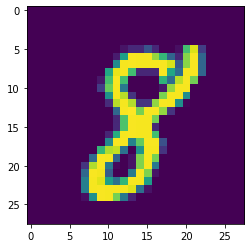

In [ ]:
plt.imshow(x_train[97])

In [ ]:
conv = Conv_op (8,3)
pool = Max_pool(2)
softmax = Softmax(13*13*8,10)


def cnn_forward_prop(image, label):

  out_p = conv.forward_prop((image / 255)-0.5)
  out_p  =  pool.forward_prop(out_p)
  out_p = softmax.forward_prop(out_p)

  cross_ent_loss = -np.log(out_p[label])
  accuracy_eval = 1 if np.argmax(out_p) == label else 0

  return out_p , cross_ent_loss , accuracy_eval


def training_cnn(image,label,learn_rate= .005):

  out,loss,acc = cnn_forward_prop(image, label)

  gradient = np.zeros(10)
  gradient[label] = -1/out[label]


  grad_back = softmax.back_prop(gradient ,learn_rate)
  grad_back = pool.back_prop(grad_back)
  grad_back = conv.back_prop(grad_back, learn_rate)

  return loss, acc


accuracy_g = []
for epoch1 in range(10):
  print('Epoch %d--->'%(epoch1+1))

  shuffle_data = np.random.permutation(len(train_images))
  train_image = train_images[shuffle_data]
  train_labels = train_labels[shuffle_data]

  loss = 0
  num_correct = 0
  for i ,(im,label ) in enumerate(zip(train_image,train_labels)):
    if i % 100 == 0:
      print('%d steps out of %d steps: Average Loss  %.3f and Accuracy: %f%%' %(i+1,n,loss/100,num_correct/100))
      loss=0
      num_correct = 0

    l1,accu = training_cnn(im, label)
    loss+=l1
    num_correct += accu
  print(num_correct)
  accuracy_g.append((num_correct*100)/n)


print('acc', (accuracy_g))
print('Testing Phase')
loss= 0
num_correct = 0
for im, label in zip(test_images,test_labels):
  _,l1,accu = cnn_forward_prop(im,label)
  loss+=l1
  num_correct+= accu


num_tests = len(test_images)
print('Test Loss:', (loss)/num_tests)
print('Test Accuracy:',(num_correct*100)/num_tests)

Epoch 1--->
1 steps out of 500 steps: Average Loss  0.000 and Accuracy: 0.000000%
101 steps out of 500 steps: Average Loss  2.370 and Accuracy: 0.090000%
201 steps out of 500 steps: Average Loss  2.388 and Accuracy: 0.050000%
301 steps out of 500 steps: Average Loss  2.356 and Accuracy: 0.090000%
401 steps out of 500 steps: Average Loss  2.387 and Accuracy: 0.060000%
14
Epoch 2--->
1 steps out of 500 steps: Average Loss  0.000 and Accuracy: 0.000000%
101 steps out of 500 steps: Average Loss  2.365 and Accuracy: 0.120000%
201 steps out of 500 steps: Average Loss  2.364 and Accuracy: 0.150000%
301 steps out of 500 steps: Average Loss  2.318 and Accuracy: 0.190000%
401 steps out of 500 steps: Average Loss  2.398 and Accuracy: 0.110000%
6
Epoch 3--->
1 steps out of 500 steps: Average Loss  0.000 and Accuracy: 0.000000%
101 steps out of 500 steps: Average Loss  2.396 and Accuracy: 0.070000%
201 steps out of 500 steps: Average Loss  2.395 and Accuracy: 0.080000%
301 steps out of 500 steps: A